# FINAL PROJECT: Low-Energy Acceleration of a Proton in a Cyclotron
# NOTEBOOK 2 - Lawrence & Livingston (1932)
### EPS 109 - Computer Simulations in Earth and Planetary Science
### Instructor: Burkhard Militzer
### Jorge Rios Corral, SID 3039754720


## Background

The **Notebook 2** presents a numerical routine to solve for the equations of motion of a proton accelerated by the cyclotron presented by Ernest Lawrence and Stanley Livingston in 1932. The previous year, Lawrence and Livinston, co-inventors of the cyclotron, achieved the first ever acceleration of protons to the order of MeV with low voltages. Their experimental setup consisted of a device with diameter of 11 in, an AC source generating a potential difference of 4000 V, and a magnetic field of 1.4 T (Lawrence & Livingston, 1932).

Lawrence, E. O., & Livingston, M. S. (1932). The production of high speed light ions without the use of high voltages. _Physical Review_, 40(1), 19. Retrieved from https://doi.org/10.1103/PhysRev.40.19



## Statement

The parameters for this cyclotron are $R$ = 13.97 cm, $d$ = 5 mm, $V_{max}$ = 4000 V, and $B$ = 1.4 T. The rest of the statement is identical to that of **Notebook 1**.




## Numerical Implementation

The equations of motion will be solved via the RK4 method to plot the trajectory of the proton accelerated by the cyclotron, and to visualize the gain in speed and kinetic energy as functions of time. The intended final kinetic energy of the particle is intended to be low so that relativistic effects are neglectable.

### Import necessary libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib.animation import FFMpegWriter

%config InlineBackend.figure_format = 'retina'


### Define useful functions for computing next positions and velocities


In [2]:
def cyclotronODE(t,Y):
    v = Y[2:4]

    drdt = v

    dvxdt = qEm + qBm * v[1]
    dvydt = -qBm * v[0]

    dvdt = np.array([dvxdt,dvydt])

    return np.concatenate((drdt,dvdt))

def freeParticleODE(t,Y):
    v = Y[2:4]
    
    drdt = v
    
    dvdt = np.array([0,0])
    
    return np.concatenate((drdt,dvdt))

def plotCyclotronDees(ax):
    th_c = np.arccos(d/2/R)
    D1x  = R * np.cos(np.linspace(-th_c,th_c))
    D1y  = R * np.sin(np.linspace(-th_c,th_c))
    D2x  = R * np.cos(np.linspace(np.pi-th_c,np.pi+th_c))
    D2y  = R * np.sin(np.linspace(np.pi-th_c,np.pi+th_c))

    ax.plot(np.append(D1x,D1x[0]),np.append(D1y,D1y[0]), 'k', linewidth=1)
    ax.plot(np.append(D2x,D2x[0]),np.append(D2y,D2y[0]), 'k', linewidth=1)


### Simulation of proton accelerated by cyclotron, solution via RK4


--------- SIMULATION FINISHED ---------

Exit time:    1.070153e-05 [s]

Final Speed:  18703649.304350402 [m/s]
              6.24% of the speed of light

Final Energy: 1826039.2025867393 [eV]



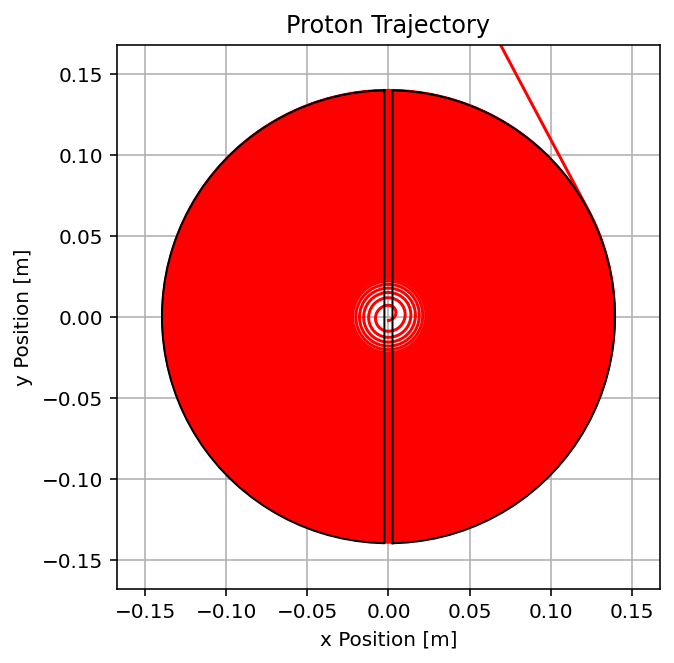

In [40]:
# Particle parameters (Proton)
m = 1.672621923e-27 # [kg]
q = 1.602176634e-19 # [C]

# Cyclotron parameters
R = 0.1397          # [m]
d = 0.005           # [m]
V_max = 4000        # [V]
Bz = -1.4           # [T]

B = np.abs(Bz)
omega = np.abs(q) * B / m

# Initialize time array
T = 2 * np.pi / omega
dt = 1e-11
t = np.arange(0,1.1e-5+dt,dt)

# Time-dependent electric field array
E = V_max / d * signal.square(omega * t)

# Initial conditions
x0  = 0
y0  = -0.5 * np.sqrt(m * V_max / (np.abs(q) * B**2))
vx0 = 0
vy0 = 0

# Initialize position and velocity array
Y = np.zeros((4,np.size(t)))
Y[:,0] = np.array([x0,y0,vx0,vy0])

# Integration through RK4 method
outside_cyclotron = False
index_crit = 0
qBm = q * Bz / m

for i in range(0,np.size(t) - 1):
    # Is particle still inside the dees?
    if np.linalg.norm(Y[0:2,i]) <= R:
        # Is particle inside or outside E-field?
        if -d/2 <= Y[0,i] and Y[0,i] <= d/2:
            qEm = q * E[i] / m
        else:
            qEm = 0

        F1 = cyclotronODE(t[i]       ,Y[:,i]          )
        F2 = cyclotronODE(t[i] + dt/2,Y[:,i] + dt/2*F1)
        F3 = cyclotronODE(t[i] + dt/2,Y[:,i] + dt/2*F2)
        F4 = cyclotronODE(t[i] + dt  ,Y[:,i] + dt*F3  )
        Y[:,i+1] = Y[:,i] + dt/6 * (F1 + 2*F2 + 2*F3 + F4)
    else:
        dYdt = freeParticleODE(t[i],Y[:,i])
        Y[:,i+1] = Y[:,i] + dYdt * dt
        
        # Store time at which particle exits cyclotron
        if outside_cyclotron == False:
            index_crit = i
            outside_cyclotron = True

# Initialize distance, speed and kinetic energy arrays
r = np.sqrt(Y[0,:]**2 + Y[1,:]**2)
v = np.sqrt(Y[2,:]**2 + Y[3,:]**2)
K = 0.5 * m * v**2

# Print simulation results
print('--------- SIMULATION FINISHED ---------\n')
print(f'Exit time:    {t[index_crit]} [s]\n')
print(f'Final Speed:  {v[-1]} [m/s]')
print(f'              {v[-1] / 299792458 * 100:.2f}% of the speed of light\n')
print(f'Final Energy: {K[-1] / 1.602176634e-19} [eV]\n')

# Plot particle trajectory
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(Y[0],Y[1],'r')
plotCyclotronDees(ax)
ax.set_title('Proton Trajectory')
ax.set_xlabel('x Position [m]'), ax.set_ylabel('y Position [m]')

ax.set_xlim(-1.2*R,1.2*R), ax.set_ylim(-1.2*R,1.2*R)
ax.set_aspect('equal', adjustable='box')
ax.grid()

plt.show()


### Plot proton trajectory, speed and kinetic energy as functions of time

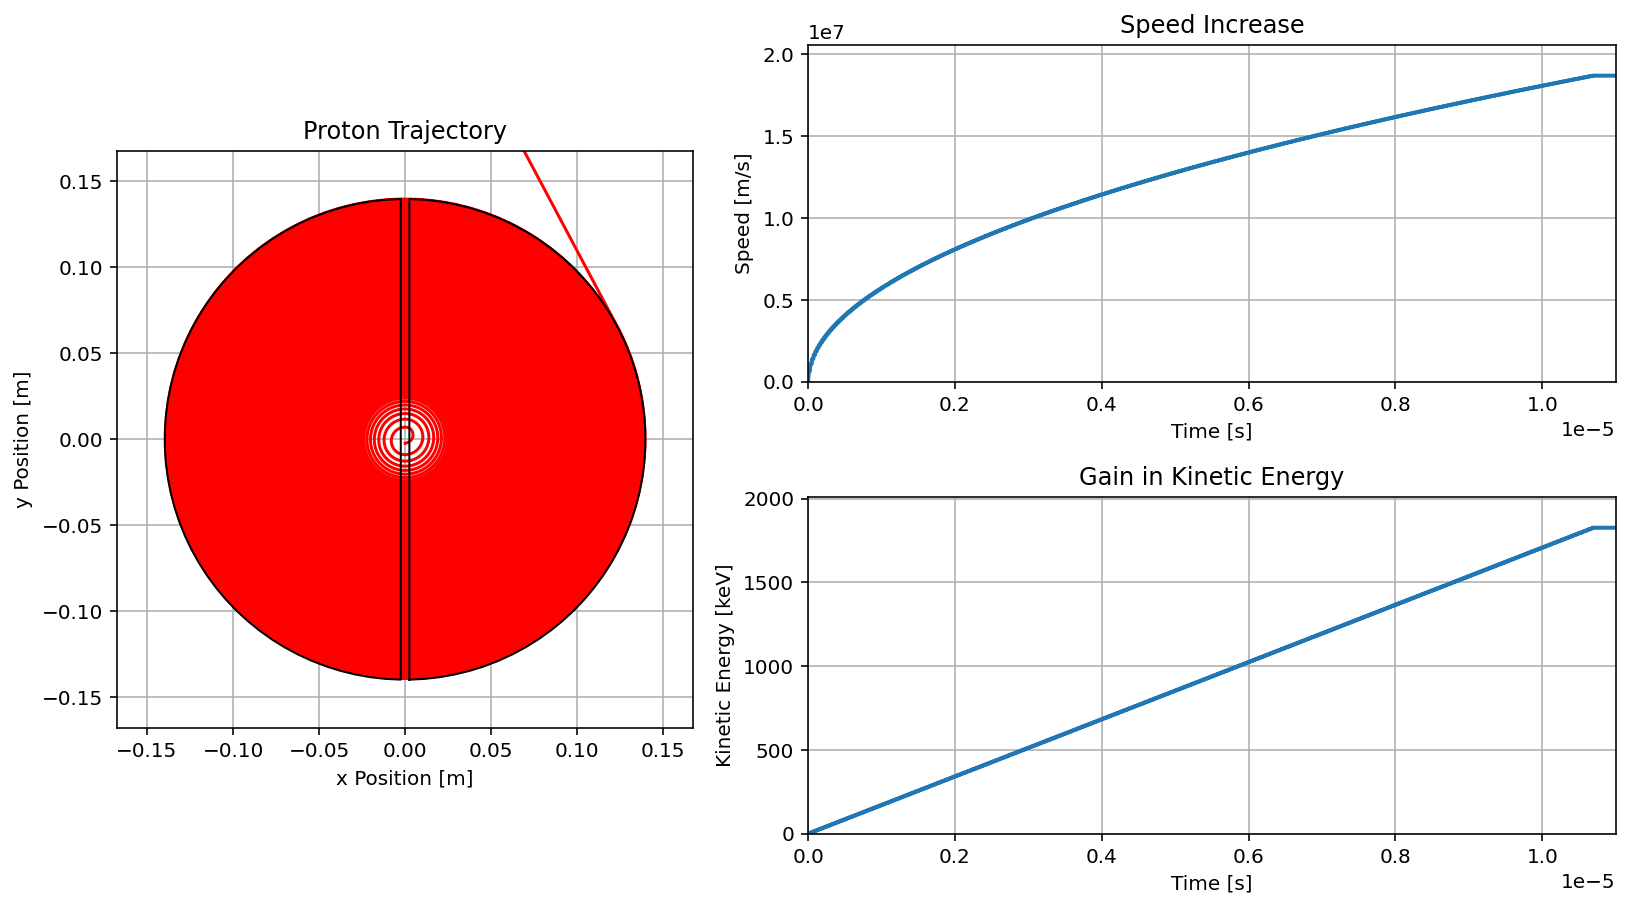

In [48]:
fig = plt.figure(figsize=(16/1.4,9/1.4))
grid = plt.GridSpec(2, 2, width_ratios=[1, 1.4], height_ratios=[1, 1])


# Plot particle trajectory
ax1 = plt.subplot(grid[:,0])
ax1.plot(Y[0],Y[1],'r')
plotCyclotronDees(ax1)
ax1.set_title('Proton Trajectory')
ax1.set_xlabel('x Position [m]'), ax1.set_ylabel('y Position [m]')

ax1.set_xlim(-1.2*R,1.2*R), ax1.set_ylim(-1.2*R,1.2*R)
ax1.set_aspect('equal', adjustable='box')
ax1.grid()


# Plot particle speed
ax2 = plt.subplot(grid[0,1])
ax2.plot(t,v, linewidth=2)
ax2.set_title('Speed Increase')
ax2.set_xlabel('Time [s]'), ax2.set_ylabel('Speed [m/s]')

ax2.set_xlim(0,t[-1]), ax2.set_ylim(0,1.1*v[-1])
ax2.grid()


# Plot particle kinetic energy
ax3 = plt.subplot(grid[1,1])
ax3.plot(t,K/1.602176634e-16, linewidth=2)
ax3.set_title('Gain in Kinetic Energy')
ax3.set_xlabel('Time [s]'), ax3.set_ylabel('Kinetic Energy [keV]')

ax3.set_xlim(0,t[-1]), ax3.set_ylim(0,1.1*K[-1]/1.602176634e-16)
ax3.grid()


plt.tight_layout()
plt.show()


### Plot proton trajectory and E-field as function of time

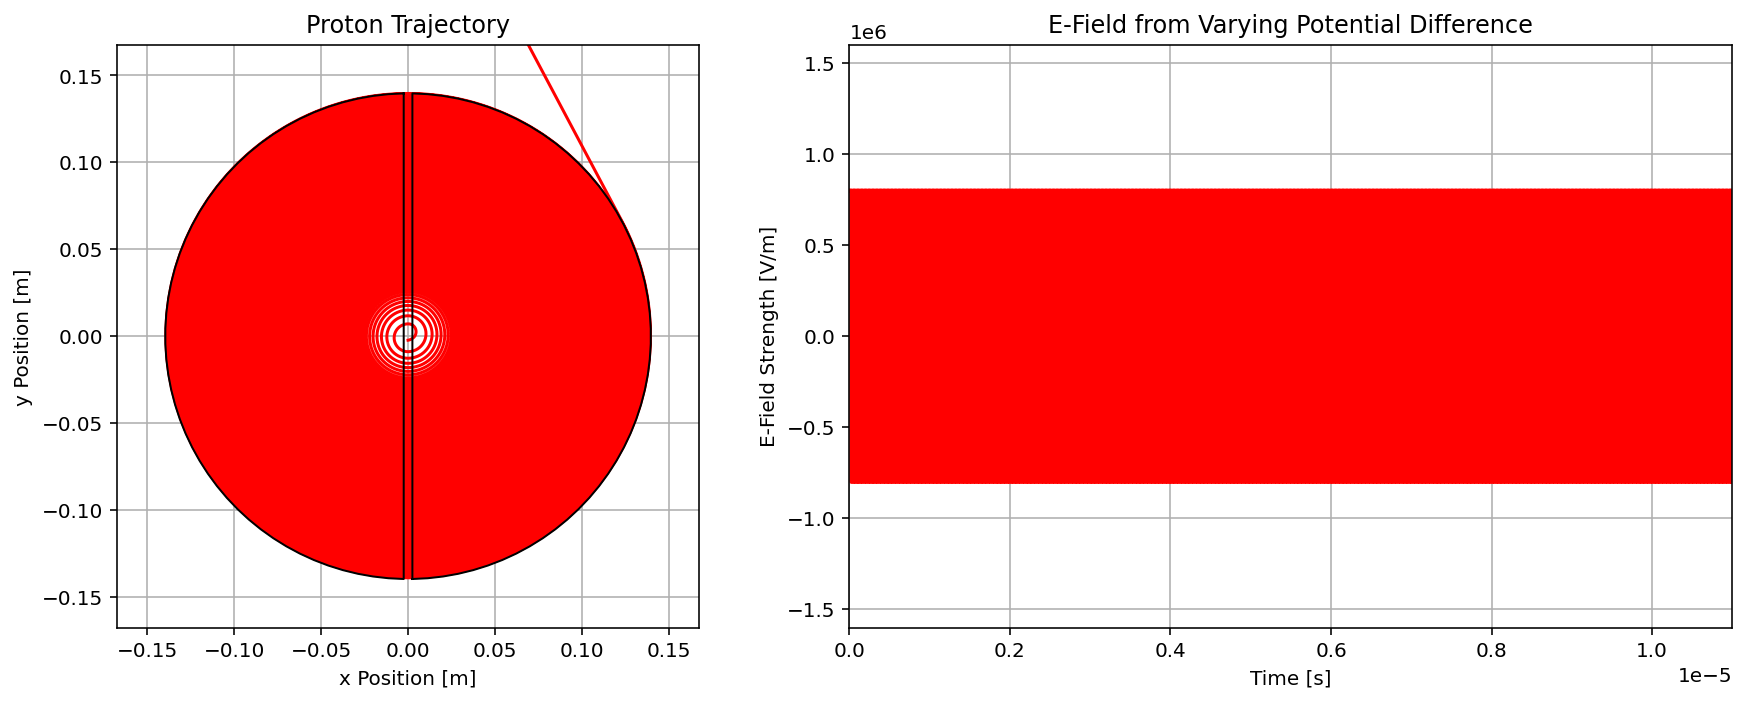

In [49]:
fig = plt.figure(figsize=(5*2.5,2*2.5))
grid = plt.GridSpec(1, 4, width_ratios=[3, 1, 1, 1])


# Plot particle trajectory
ax1 = plt.subplot(grid[0])
ax1.plot(Y[0],Y[1],'r')
plotCyclotronDees(ax1)
ax1.set_title('Proton Trajectory')
ax1.set_xlabel('x Position [m]'), ax1.set_ylabel('y Position [m]')

ax1.set_xlim(-1.2*R,1.2*R), ax1.set_ylim(-1.2*R,1.2*R)
ax1.set_aspect('equal', adjustable='box')
ax1.grid()


# Plot electric field
ax2 = plt.subplot(grid[1:])
ax2.plot(t,E,'r', linewidth=2)
ax2.set_title('E-Field from Varying Potential Difference')
ax2.set_xlabel('Time [s]'), ax2.set_ylabel('E-Field Strength [V/m]')

ax2.set_xlim(0,t[-1]), ax2.set_ylim(2*min(E),2*max(E))
ax2.grid()


plt.tight_layout()
plt.show()


### Export Video Animations


In [58]:
%matplotlib qt

# Initialize particle trajectory plot
fig, ax = plt.subplots(figsize=(6,6), dpi=200)
line1, = ax.plot(Y[0,0],Y[1,0],'r')
line2, = ax.plot(Y[0,0],Y[1,0],'ro')
plotCyclotronDees(ax)
ax.set_xlabel('x Position [m]'), ax.set_ylabel('y Position [m]')

ax.set_xlim(-1.2*R,1.2*R), ax.set_ylim(-1.2*R,1.2*R)
ax.set_aspect('equal', adjustable='box')
ax.grid()

plt.pause(0.01)

# Generate video animation of particle trajectory
frames = 0

metadata = dict(title='test_4', artist='JorgeRiosCorral',comment='')
writer = FFMpegWriter(fps=60, metadata=metadata,bitrate=200000)

with writer.saving(fig, "test_4.mp4", dpi=200):
    for t_iter in range(np.size(t)):
        if t_iter % int(np.size(t)/600) == 0:
            frames += 1
            ax.set_title(f'Proton Trajectory at t = {t[t_iter] * 1e5:.2f}e-5 [s]')
            line1.set_data(Y[0,0:t_iter+1],Y[1,0:t_iter+1])
            line2.set_data(Y[0,t_iter],Y[1,t_iter])
            fig.canvas.draw()
            plt.pause(0.01)
            writer.grab_frame()

    plt.show()


In [60]:
%matplotlib qt

# Initialize plot grid
fig = plt.figure(figsize=(16/1.7,9/1.7), dpi=200)
grid = plt.GridSpec(2, 2, width_ratios=[1, 1.4], height_ratios=[1, 1])

# Initialize particle trajectory plot
ax1 = plt.subplot(grid[:,0])
line1_1, = ax1.plot(Y[0,0],Y[1,0],'r')
line1_2, = ax1.plot(Y[0,0],Y[1,0],'ro')
plotCyclotronDees(ax1)
ax1.set_xlabel('x Position [m]'), ax1.set_ylabel('y Position [m]')

ax1.set_xlim(-1.2*R,1.2*R), ax1.set_ylim(-1.2*R,1.2*R)
ax1.set_aspect('equal', adjustable='box')
ax1.grid()


# Initialize particle speed plot
ax2 = plt.subplot(grid[0,1])
line2, = ax2.plot(t[0],v[0], linewidth=2)
ax2.set_title('Speed Increase')
ax2.set_xlabel('Time [s]'), ax2.set_ylabel('Speed [m/s]')

ax2.set_xlim(0,t[-1]), ax2.set_ylim(0,1.1*v[-1])
ax2.grid()


# Initialize particle kinetic energy plot
ax3 = plt.subplot(grid[1,1])
line3, = ax3.plot(t[0],K[0]/1.602176634e-16, linewidth=2)
ax3.set_title('Gain in Kinetic Energy')
ax3.set_xlabel('Time [s]'), ax3.set_ylabel('Kinetic Energy [keV]')

ax3.set_xlim(0,t[-1]), ax3.set_ylim(0,1.1*K[-1]/1.602176634e-16)
ax3.grid()


plt.tight_layout()
plt.pause(0.01)


# Generate video animation of particle trajectory, speed and kinetic energy
frames = 0

metadata = dict(title='test_5', artist='JorgeRiosCorral',comment='')
writer = FFMpegWriter(fps=60, metadata=metadata,bitrate=200000)

with writer.saving(fig, "test_5.mp4", dpi=200):
    for t_iter in range(np.size(t)):
        if t_iter % int(np.size(t)/600) == 0:
            frames += 1
            ax1.set_title(f'Proton Trajectory at t = {t[t_iter] * 1e5:.2f}e-5 [s]')
            line1_1.set_data(Y[0,0:t_iter+1],Y[1,0:t_iter+1])
            line1_2.set_data(Y[0,t_iter],Y[1,t_iter])

            line2.set_data(t[0:t_iter+1],v[0:t_iter+1])

            line3.set_data(t[0:t_iter+1],K[0:t_iter+1]/1.602176634e-16)

            fig.canvas.draw()
            plt.pause(0.01)
            writer.grab_frame()

    plt.show()
